In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import json
import math
import h5py
import seaborn as sns
from keras.models import model_from_json
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ImportError: No module named 'keras'

In [2]:
new_size_col,new_size_row = 200, 66
base_dir = "./data/"

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


def trans_image(image,steer):
    tr_x = np.random.normal(0, 10, 1)[0]
    tr_y = np.random.normal(0, 10, 1)[0]
    steer_ang = steer + (tr_x * 0.004)
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(image.shape[1], image.shape[0]))
    return image_tr,steer_ang


def preprocessImage(image):
    shape = image.shape
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    return image


def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    adj_value = 0.25
    if (i_lrc == 0):
        path_file = base_dir + line_data['left'][0].strip()
        shift_ang = adj_value
    if (i_lrc == 1):
        path_file = base_dir + line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = base_dir + line_data['right'][0].strip()
        shift_ang = adj_value * -1
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer = trans_image(image,y_steer)
    image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer


def batch_generator(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering
        

def get_model():
    ch, row, col = 3, 80, 160  # camera format

    model = Sequential()
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(row, col, ch)))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse", metrics=['mse'])
    return model
        
        
def get_model_nvidia():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape = (new_size_row, new_size_col, 3)))
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode="valid", init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode="valid", init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode="valid", init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode="valid", init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode="valid", init="he_normal"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164, init="he_normal"))
    model.add(ELU())
    model.add(Dense(100, init="he_normal"))
    model.add(ELU())
    model.add(Dense(50, init="he_normal"))
    model.add(ELU())
    model.add(Dense(10, init="he_normal"))
    model.add(ELU())
    model.add(Dense(1, init="he_normal"))
    model.compile(optimizer="adam", loss="mse", metrics=['mse'])
    return model

In [3]:
data = pd.read_csv("./data/driving_log.csv")

In [4]:
epochs = 8
batch_size = 256
model = get_model_nvidia()
train_generator = batch_generator(data, batch_size)
validation_generator = batch_generator(data, batch_size)
train = False

if train:
    for i in range(epochs):

        pr_threshold = (1/(i+1))
        print(pr_threshold)
        model.fit_generator(train_generator, samples_per_epoch=25600, nb_epoch=1,
                 verbose=1, validation_data=validation_generator, nb_val_samples=2560)
        model.save_weights("model_"+str(i)+".h5")
        model_json = model.to_json()
        with open("model_"+str(i)+".json", 'w') as outfile:
            outfile.write(model_json)

## Visualization of data

In [5]:
index = 0

line_data = data.iloc[[index]]
path_file = base_dir + line_data['center'][0]
image = cv2.imread(path_file)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
steer = line_data['steering'][0]
aug_imgs = []
aug_steer = []
for i in range(3):
    img_a, steer_a = preprocess_image_file_train(line_data)
    aug_imgs.append(img_a)
    aug_steer.append(steer_a)

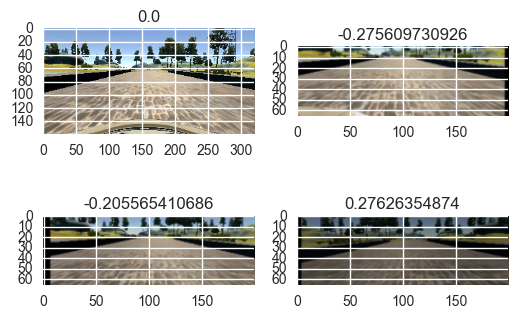

In [6]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(image)
axarr[0, 0].set_title(steer)
axarr[0, 1].imshow(aug_imgs[0])
axarr[0, 1].set_title(aug_steer[0])
axarr[1, 0].imshow(aug_imgs[1])
axarr[1, 0].set_title(aug_steer[1])
axarr[1, 1].imshow(aug_imgs[2])
axarr[1, 1].set_title(aug_steer[2])
plt.savefig("data_example.png")

## Visualize some weights

In [7]:
weights_path = 'model.h5'
model_path = "model.json"

with open(model_path, 'r') as jfile:
    model = model_from_json(jfile.read())
model.load_weights(weights_path)

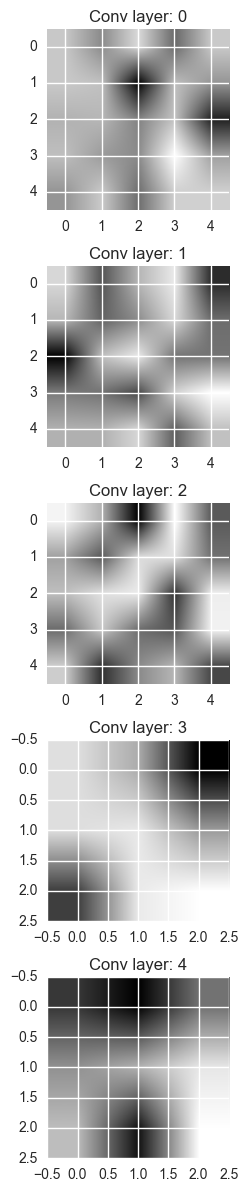

In [8]:
f, axarr = plt.subplots(5, figsize=(12,12))
for i, index in enumerate([1,3,5,7,9]):
    axarr[i].imshow(np.max(model.layers[index].get_weights()[0],2)[:,:,12], cmap='Greys')
    axarr[i].set_title("Conv layer: {}".format(i))
plt.tight_layout()
plt.savefig("conv_layers.png")

## Visualization of architecture

In [13]:
from keras.utils.visualize_util import plot
plot(model, to_file='model_arch.png')

AttributeError: module 'pydot' has no attribute 'find_graphviz'

In [15]:
!pip install pydot-ng

  Running setup.py bdist_wheel for pydot-ng ... - \ | done
  Stored in directory: /Users/tfolkman/Library/Caches/pip/wheels/4f/09/d5/f96fd2578831e1b9021c634f057ab5306a3e4287efa800de29
Successfully built pydot-ng
